In [1]:
!pip install xgboost
!pip install shap


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import yeojohnson
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, GridSearchCV
from DensityAwareClustering import DensityAwareClustering
import shap

In [3]:
datapath = "/Users/halvornedrebo/Documents/Programmering/INFO381/data/"

In [4]:
#data = pd.read_csv('data/fraud.csv', index_col=0)


In [5]:
"""le = LabelEncoder()


def clean_data(filename):

    print("Importing data...")
    data = pd.read_csv(datapath+filename, index_col=0)

    dac = DensityAwareClustering(eps=0.5, min_samples=max(5, int(len(data) * 0.01)))

    print("splitting time columns...")
    data["trans_date_trans_time"] = pd.to_datetime(data["trans_date_trans_time"])

    data['trans_minute'] = data['trans_date_trans_time'].dt.minute
    data['trans_hour'] = data['trans_date_trans_time'].dt.hour
    data['trans_day'] = data['trans_date_trans_time'].dt.day
    data['trans_month'] = data['trans_date_trans_time'].dt.month
    data['trans_year'] = data['trans_date_trans_time'].dt.year
    data['trans_dayofweek'] = data['trans_date_trans_time'].dt.dayofweek

    data["dob"] = pd.to_datetime(data["dob"])
    data["dob_day"] = data["dob"].dt.day
    data["dob_month"] = data["dob"].dt.month
    data["dob_year"] = data["dob"].dt.year


    print("Handling skewing...")
    data["amt"] = np.log(data["amt"])
    data["city_pop"] = np.log(data["city_pop"])
    
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
    data["dob_year"] = quantile_transformer.fit_transform(data["dob_year"].values.reshape(-1, 1)).flatten()


    print("Cyclically encoding features...")
    data["trans_minute_sin"] = np.sin(2*np.pi *data["trans_minute"]/60)
    data["trans_minute_cos"] = np.cos(2*np.pi *data["trans_minute"]/60)
    data["trans_hour_sin"] = np.sin(2*np.pi *data["trans_hour"]/24)
    data["trans_hour_cos"] = np.cos(2*np.pi *data["trans_hour"]/24)
    data["trans_day_sin"] = np.sin(2*np.pi *data["trans_day"]/31)
    data["trans_day_cos"] = np.cos(2*np.pi *data["trans_day"]/31)
    data["trans_month_sin"] = np.sin(2*np.pi *data["trans_month"]/12)
    data["trans_month_cos"] = np.cos(2*np.pi *data["trans_month"]/12)
    data["trans_dayofweek_sin"] = np.sin(2*np.pi *data["trans_dayofweek"]/7)
    data["trans_dayofweek_cos"] = np.cos(2*np.pi *data["trans_dayofweek"]/7)
    data["dob_day_sin"] = np.sin(2*np.pi *data["dob_day"]/31)
    data["dob_day_cos"] = np.cos(2*np.pi *data["dob_day"]/31)
    data["dob_month_sin"] = np.sin(2*np.pi *data["dob_month"]/12)
    data["dob_month_cos"] = np.cos(2*np.pi *data["dob_month"]/12)

    data, centroids = dac.find_natural_clusters(data)

    # uncomment if you want to visualize the clustering results
    dac.visualize_clusters(data, centroids)

    data = data.drop(["trans_minute", "trans_hour", "trans_day", "trans_month", 
                      "trans_dayofweek", "dob_day", "dob_month", "long", "merch_long",
                      "lat", "merch_lat", "cc_num", "unix_time", "trans_date_trans_time",
                      "first", "last", "dob", "zip",
                      "trans_num"], axis=1)
    
    cat_data = data.select_dtypes(include=["object"])

    print("Encoding categorical features...")
    for col in cat_data.columns:
        data[col] = le.fit_transform(data[col])

    tobnormalized = ["amt", "city_pop", "trans_year",
                     "merchant", "city", "state", "category",
                     "street", "job",
                     ]

    scaler = StandardScaler()

    print("Scaling features...")
    for col in tobnormalized:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1)).flatten()
        
    return data"""

'le = LabelEncoder()\n\n\ndef clean_data(filename):\n\n    print("Importing data...")\n    data = pd.read_csv(datapath+filename, index_col=0)\n\n    dac = DensityAwareClustering(eps=0.5, min_samples=max(5, int(len(data) * 0.01)))\n\n    print("splitting time columns...")\n    data["trans_date_trans_time"] = pd.to_datetime(data["trans_date_trans_time"])\n\n    data[\'trans_minute\'] = data[\'trans_date_trans_time\'].dt.minute\n    data[\'trans_hour\'] = data[\'trans_date_trans_time\'].dt.hour\n    data[\'trans_day\'] = data[\'trans_date_trans_time\'].dt.day\n    data[\'trans_month\'] = data[\'trans_date_trans_time\'].dt.month\n    data[\'trans_year\'] = data[\'trans_date_trans_time\'].dt.year\n    data[\'trans_dayofweek\'] = data[\'trans_date_trans_time\'].dt.dayofweek\n\n    data["dob"] = pd.to_datetime(data["dob"])\n    data["dob_day"] = data["dob"].dt.day\n    data["dob_month"] = data["dob"].dt.month\n    data["dob_year"] = data["dob"].dt.year\n\n\n    print("Handling skewing...")\n 

In [6]:
le = LabelEncoder()

def clean_data(filename):

    print("Importing data...")
    data = pd.read_csv(datapath+filename, index_col=0)

    dac = DensityAwareClustering(eps=0.5, min_samples=max(5, int(len(data) * 0.01)))

    print("splitting time columns...")
    data["trans_date_trans_time"] = pd.to_datetime(data["trans_date_trans_time"])

    data['trans_minute'] = data['trans_date_trans_time'].dt.minute
    data['trans_hour'] = data['trans_date_trans_time'].dt.hour
    data['trans_day'] = data['trans_date_trans_time'].dt.day
    data['trans_month'] = data['trans_date_trans_time'].dt.month
    data['trans_year'] = data['trans_date_trans_time'].dt.year
    data['trans_dayofweek'] = data['trans_date_trans_time'].dt.dayofweek

    data["dob"] = pd.to_datetime(data["dob"])
    data["dob_day"] = data["dob"].dt.day
    data["dob_month"] = data["dob"].dt.month
    data["dob_year"] = data["dob"].dt.year


    # Beholder dette inntil videre. Kan være det trengs i senere arbeid
    """
    print("Handling skewing...")
    data["amt"] = np.log(data["amt"])
    data["city_pop"] = np.log(data["city_pop"])
    
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
    data["dob_year"] = quantile_transformer.fit_transform(data["dob_year"].values.reshape(-1, 1)).flatten()

    print("Cyclically encoding features...")
    data["trans_minute_sin"] = np.sin(2*np.pi *data["trans_minute"]/60)
    data["trans_minute_cos"] = np.cos(2*np.pi *data["trans_minute"]/60)
    data["trans_hour_sin"] = np.sin(2*np.pi *data["trans_hour"]/24)
    data["trans_hour_cos"] = np.cos(2*np.pi *data["trans_hour"]/24)
    data["trans_day_sin"] = np.sin(2*np.pi *data["trans_day"]/31)
    data["trans_day_cos"] = np.cos(2*np.pi *data["trans_day"]/31)
    data["trans_month_sin"] = np.sin(2*np.pi *data["trans_month"]/12)
    data["trans_month_cos"] = np.cos(2*np.pi *data["trans_month"]/12)
    data["trans_dayofweek_sin"] = np.sin(2*np.pi *data["trans_dayofweek"]/7)
    data["trans_dayofweek_cos"] = np.cos(2*np.pi *data["trans_dayofweek"]/7)
    data["dob_day_sin"] = np.sin(2*np.pi *data["dob_day"]/31)
    data["dob_day_cos"] = np.cos(2*np.pi *data["dob_day"]/31)
    data["dob_month_sin"] = np.sin(2*np.pi *data["dob_month"]/12)
    data["dob_month_cos"] = np.cos(2*np.pi *data["dob_month"]/12)
    """

    #print("Finding natural clusters...")
    #data, centroids = dac.find_natural_clusters(data)

    # uncomment if you want to visualize the clustering results
    #dac.visualize_clusters(data, centroids)

    print("Dropping columns...")
    data = data.drop(["long", "merch_long", "lat", 
                      "merch_lat", "unix_time", 
                      "trans_date_trans_time",
                      "first", "last", "dob",
                      ], axis=1)
    
    print("Rounding columns...")
    data[["trans_minute", "trans_hour", "trans_day", "trans_month", "trans_year", "trans_dayofweek", "dob_year", "dob_month", "dob_day", "city_pop", "zip", "cc_num"]] = data[["trans_minute", "trans_hour", "trans_day", "trans_month", "trans_year", "trans_dayofweek", "dob_year", "dob_month", "dob_day", "city_pop", "zip", "cc_num"]].round(decimals=0)

    data["amt"] = data["amt"].round(decimals=2)

    cat_data = data.select_dtypes(include=["object"])

    print(data.columns)

    print("Encoding categorical features...")
    label_encoders = {}
    inverse_mappings = {}

    for col in cat_data.columns:
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
        inverse_mappings[col] = dict(zip(le.transform(le.classes_), le.classes_))

    print("Rounding categorical columns...")
    data[["merchant", "category", "street", "city", "state", "job"]] = data[["merchant", "category", "street", "city", "state", "job"]].round(decimals=0)

    """
    tobnormalized = ["amt", "city_pop", "trans_year",
                     "merchant", "city", "state", "category",
                     "street", "job",
                     ]

    scaler = StandardScaler()

    print("Scaling features...")
    for col in tobnormalized:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1)).flatten() 
    """
    print(data.head())

    return data, inverse_mappings

In [7]:
data, inverse_mapping = clean_data("fraud.csv")  

Importing data...
splitting time columns...
Dropping columns...
Rounding columns...
Index(['cc_num', 'merchant', 'category', 'amt', 'gender', 'street', 'city',
       'state', 'zip', 'city_pop', 'job', 'trans_num', 'is_fraud',
       'trans_minute', 'trans_hour', 'trans_day', 'trans_month', 'trans_year',
       'trans_dayofweek', 'dob_day', 'dob_month', 'dob_year'],
      dtype='object')
Encoding categorical features...
Rounding categorical columns...
             cc_num  merchant  category     amt  gender  street  city  state  \
0  2703186189652095       514         8    4.97       0     576   532     27   
1      630423337322       241         4  107.23       0     439   619     47   
2    38859492057661       390         0  220.11       1     610   474     13   
3  3534093764340240       360         2   45.00       1     945    84     26   
4   375534208663984       297         9   41.96       1     422   217     45   

     zip  city_pop  ...  is_fraud  trans_minute  trans_hour  tr

In [8]:
inverse_mapping['job']

{0: 'Academic librarian',
 1: 'Accountant, chartered',
 2: 'Accountant, chartered certified',
 3: 'Accountant, chartered public finance',
 4: 'Accounting technician',
 5: 'Acupuncturist',
 6: 'Administrator',
 7: 'Administrator, arts',
 8: 'Administrator, charities/voluntary organisations',
 9: 'Administrator, education',
 10: 'Administrator, local government',
 11: 'Advertising account executive',
 12: 'Advertising account planner',
 13: 'Advertising copywriter',
 14: 'Advice worker',
 15: 'Aeronautical engineer',
 16: 'Agricultural consultant',
 17: 'Aid worker',
 18: 'Air broker',
 19: 'Air cabin crew',
 20: 'Air traffic controller',
 21: 'Airline pilot',
 22: 'Ambulance person',
 23: 'Amenity horticulturist',
 24: 'Analytical chemist',
 25: 'Animal nutritionist',
 26: 'Animal technologist',
 27: 'Animator',
 28: 'Applications developer',
 29: 'Arboriculturist',
 30: 'Archaeologist',
 31: 'Architect',
 32: 'Architectural technologist',
 33: 'Archivist',
 34: 'Armed forces logistics/

In [9]:

X = data.drop("is_fraud", axis=1)
y = data["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
"""categorical = ["amt", "city_pop", "trans_year","merchant", "city", "state", "category","street", "job"]
for col in categorical:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')"""

'categorical = ["amt", "city_pop", "trans_year","merchant", "city", "state", "category","street", "job"]\nfor col in categorical:\n    X_train[col] = X_train[col].astype(\'category\')\n    X_test[col] = X_test[col].astype(\'category\')'

In [11]:
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, device="cuda")

model.fit(X_train, y_train)

/Users/halvornedrebo/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:17:59] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
y_pred = model.predict(X_test)
xgb_rmse = np.sqrt(MSE(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

print(f"RMSE: {xgb_rmse:.2f}")
print(classification_report(y_test, y_pred))
print(cm)

RMSE: 0.03
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.97      0.85      0.91      1953

    accuracy                           1.00    370479
   macro avg       0.98      0.92      0.95    370479
weighted avg       1.00      1.00      1.00    370479

[[368471     55]
 [   293   1660]]


<Figure size 1000x800 with 0 Axes>

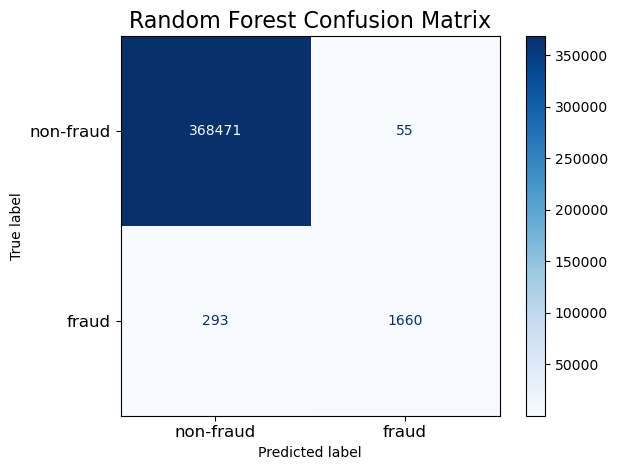

In [13]:
class_names = ["non-fraud", "fraud"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("confusion_matrix.png", bbox_inches='tight')

In [14]:
explainer = shap.TreeExplainer(model)
explanation = explainer(X_test)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - y_pred).max()

17.379148483276367

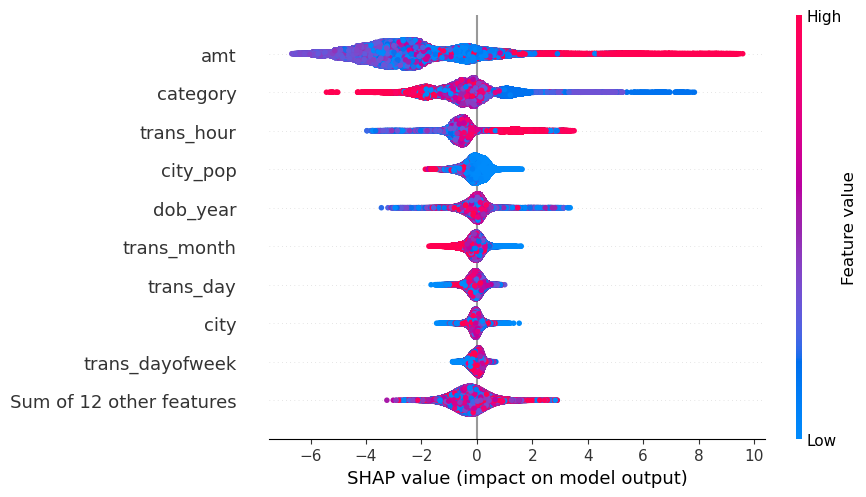

In [15]:
shap.plots.beeswarm(explanation)

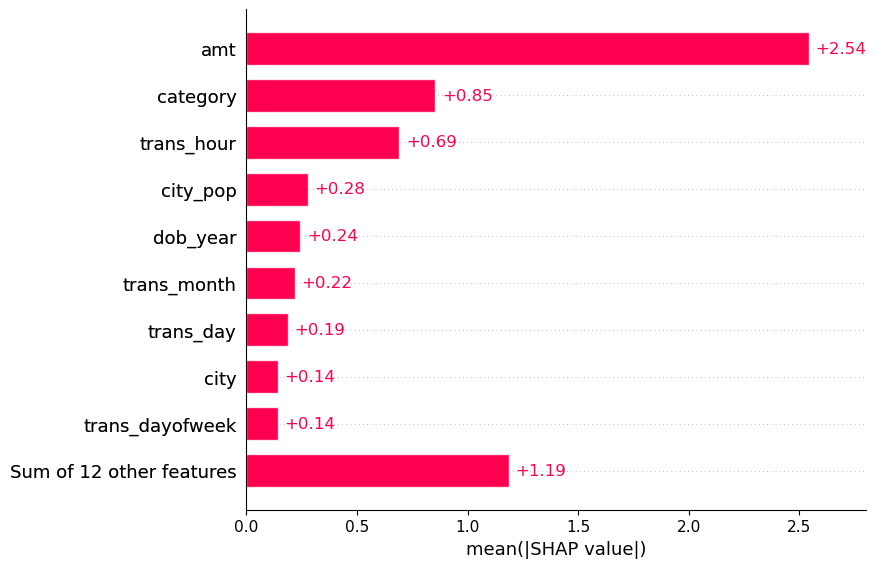

In [16]:
shap.plots.bar(explanation)

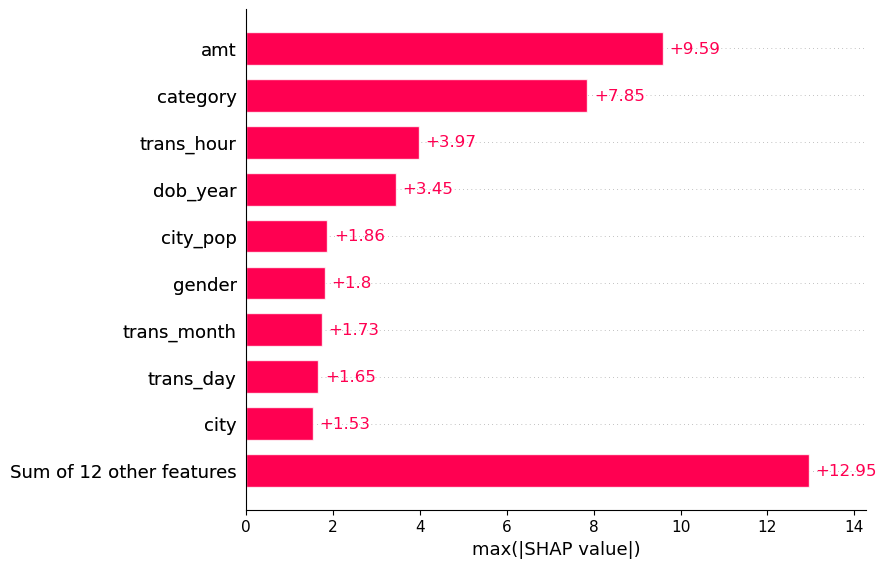

In [17]:
shap.plots.bar(explanation.abs.max(0))

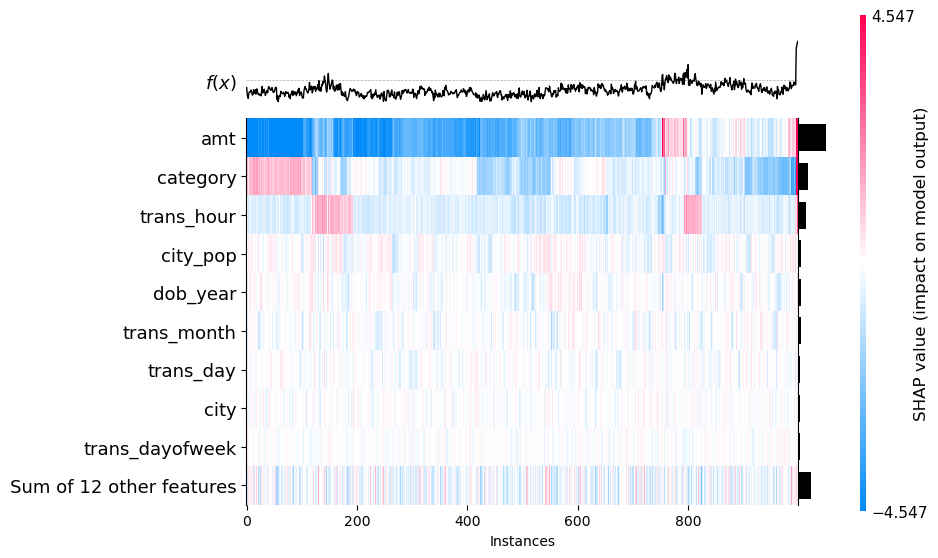

<AxesSubplot:xlabel='Instances'>

In [18]:
shap.plots.heatmap(explanation[:1000])

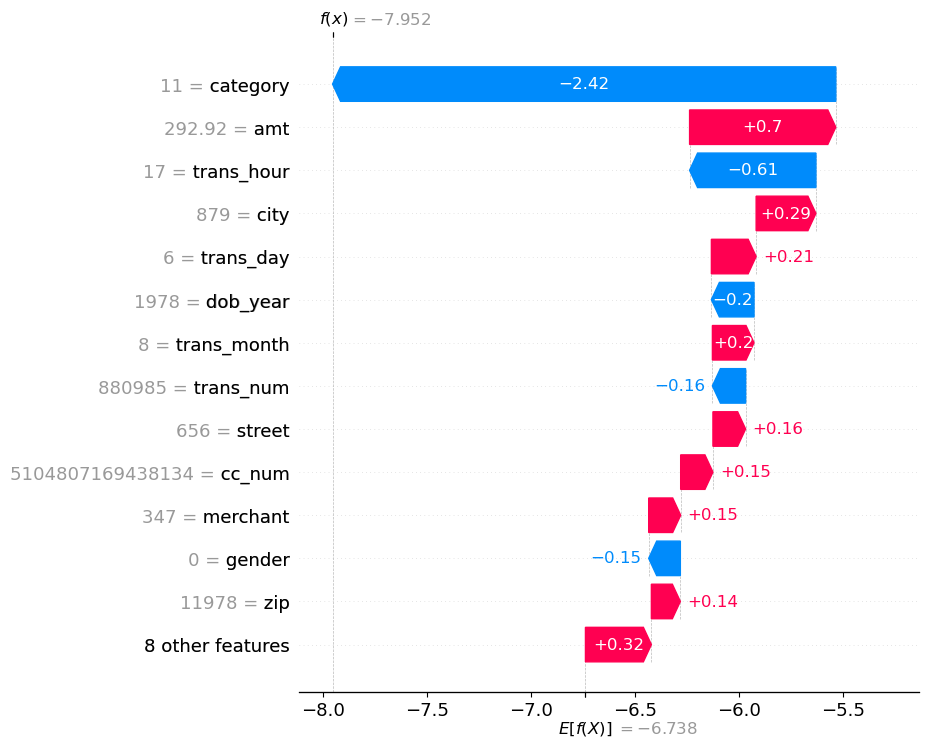

In [19]:
shap.plots.waterfall(explanation[100], max_display=14)

In [20]:
!pip install alibi


In [21]:
from alibi.explainers import AnchorTabular
feature_names = X_train.columns.tolist()
predict_fn = lambda x: model.predict_proba(x)[:, 1]
#predict_fn = lambda x: model.predict(le.transform(x))


explainer = AnchorTabular(predict_fn, feature_names)
explainer.fit(X_train.to_numpy())

instance = X_test.iloc[100].to_numpy()
explanation = explainer.explain(instance, verbose=True, threshold=0.80)


Best: 60 (mean:0.0000000000, n: 85, lb:0.0000) Worst: 35 (mean:0.0000, n: 20, ub:0.5262) B = 0.53
Best: 60 (mean:0.0000000000, n: 185, lb:0.0000) Worst: 8 (mean:0.0000, n: 21, ub:0.5279) B = 0.53
Best: 60 (mean:0.0000000000, n: 285, lb:0.0000) Worst: 41 (mean:0.0000, n: 22, ub:0.5220) B = 0.52
Best: 60 (mean:0.0000000000, n: 385, lb:0.0000) Worst: 19 (mean:0.0000, n: 24, ub:0.4988) B = 0.50
Best: 60 (mean:0.0000000000, n: 485, lb:0.0000) Worst: 23 (mean:0.0000, n: 26, ub:0.4768) B = 0.48
Best: 60 (mean:0.0000000000, n: 585, lb:0.0000) Worst: 52 (mean:0.0000, n: 27, ub:0.4683) B = 0.47
Best: 60 (mean:0.0000000000, n: 685, lb:0.0000) Worst: 2 (mean:0.0000, n: 29, ub:0.4481) B = 0.45
Best: 60 (mean:0.0000000000, n: 785, lb:0.0000) Worst: 11 (mean:0.0000, n: 30, ub:0.4400) B = 0.44
Best: 60 (mean:0.0000000000, n: 885, lb:0.0000) Worst: 36 (mean:0.0000, n: 41, ub:0.3479) B = 0.35
Best: 60 (mean:0.0000000000, n: 985, lb:0.0000) Worst: 45 (mean:0.0000, n: 43, ub:0.3368) B = 0.34
Best: 60 (mea

Could not find an anchor satisfying the 0.8 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Best of size  57 :
4 0.0 0.0 0.007307514190660267
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60) mean = 0.00 lb = 0.00 ub = 0.01 coverage: 0.00 n: 314
Best of size  58 :
3 0.0 0.0 0.007307514190660267
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60) mean = 0.00 lb = 0.00 ub = 0.01 coverage: 0.00 n: 314
Best of size  59 :
2 0.0 0.0 0.015235539400716085
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60) mean = 0.00 lb = 0.00 ub = 0.02 coverage: 0.00 n: 150
Best of size  60 :


In [ ]:
print("\n--- Anchor Explanation ---")
print(f"Anchor rule: {' AND '.join(explanation.anchor)}")


--- Anchor Explanation ---
Anchor rule: 1975.00 < dob_year <= 1987.00 AND dob_day <= 8.00 AND 2443.00 < city_pop <= 20328.00 AND 27.00 < state <= 38.00 AND cc_num > 4642255475285942.00 AND 463279.00 < trans_num <= 926507.00 AND 1.00 < trans_dayofweek <= 3.00 AND category > 10.00 AND amt > 83.11 AND 346.00 < merchant <= 514.00 AND city > 684.00 AND 131.00 < job <= 252.00 AND zip <= 26237.00 AND 490.00 < street <= 731.00 AND 4.00 < dob_month <= 7.00 AND trans_minute <= 14.00 AND 7.00 < trans_month <= 10.00 AND trans_day <= 8.00 AND gender <= 0.00 AND 14.00 < trans_hour <= 19.00 AND 2019.00 < trans_year <= 2020.00
Precision: 0.00
Coverage: 0.00


In [35]:
def decode_anchor(anchor_rules, inverse_mappings):
    decoded_rules = []
    for rule in anchor_rules:
        if ' = ' in rule:
            feature, value = rule.split(' = ')
            if feature in inverse_mappings:
                original_value = inverse_mappings[feature].get(int(value), value)
                decoded_rule = f"{feature} = {original_value}"
                decoded_rules.append(decoded_rule)
            else:
                decoded_rules.append(rule)
        else:
            # If the rule doesn't have ' = ', leave it unchanged
            decoded_rules.append(rule)
    return decoded_rules


In [37]:
decoded_anchor = decode_anchor(explanation.anchor, inverse_mapping)
print(" AND ".join(decoded_anchor))


1975.00 < dob_year <= 1987.00 AND dob_day <= 8.00 AND 2443.00 < city_pop <= 20328.00 AND 27.00 < state <= 38.00 AND cc_num > 4642255475285942.00 AND 463279.00 < trans_num <= 926507.00 AND 1.00 < trans_dayofweek <= 3.00 AND category > 10.00 AND amt > 83.11 AND 346.00 < merchant <= 514.00 AND city > 684.00 AND 131.00 < job <= 252.00 AND zip <= 26237.00 AND 490.00 < street <= 731.00 AND 4.00 < dob_month <= 7.00 AND trans_minute <= 14.00 AND 7.00 < trans_month <= 10.00 AND trans_day <= 8.00 AND gender <= 0.00 AND 14.00 < trans_hour <= 19.00 AND 2019.00 < trans_year <= 2020.00


In [23]:
from alibi.explainers import AnchorTabular

# Limit to fewer features temporarily for testing
selected_features = ['amt','category','trans_hour','dob_year']
#selected_features = ['amt', 'category', 'trans_hour', 'dob_year', 'trans_month','city_pop','gender']
X_small = X_train[selected_features].copy()
X_test_small = X_test[selected_features].copy()
      

# Retrain model on fewer features
model_small = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, device="cuda")
model_small.fit(X_small, y_train)



/Users/halvornedrebo/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:23:54] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [24]:
y_pred_small = model_small.predict(X_test_small)
cm_small = confusion_matrix(y_test, y_pred_small)

print(classification_report(y_test, y_pred_small))
print(cm_small)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.92      0.79      0.85      1953

    accuracy                           1.00    370479
   macro avg       0.96      0.90      0.93    370479
weighted avg       1.00      1.00      1.00    370479

[[368392    134]
 [   404   1549]]


<Figure size 1000x800 with 0 Axes>

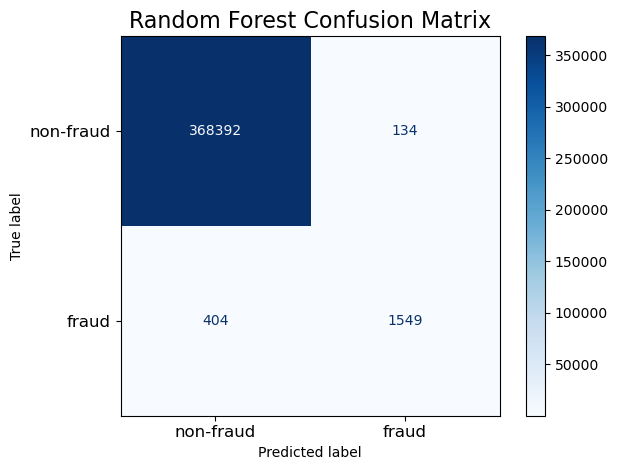

In [25]:
class_names = ["non-fraud", "fraud"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_small, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("confusion_matrix.png", bbox_inches='tight')

In [26]:
# Set up Anchor
feature_names = X_small.columns.tolist()
predict_fn = lambda x: model_small.predict_proba(x)[:, 1]

explainer = AnchorTabular(predict_fn, feature_names)
explainer.fit(X_small.to_numpy())

# Run with lower threshold and verbose mode
instance = X_test_small.iloc[100].to_numpy()
exp = explainer.explain(instance, threshold=0.70, verbose=True)
print(exp.anchor)

Best: 11 (mean:0.0000000000, n: 68, lb:0.0000) Worst: 2 (mean:0.0000, n: 19, ub:0.5000) B = 0.50
Best: 11 (mean:0.0000000000, n: 168, lb:0.0000) Worst: 5 (mean:0.0000, n: 21, ub:0.4866) B = 0.49
Best: 11 (mean:0.0000000000, n: 268, lb:0.0000) Worst: 4 (mean:0.0000, n: 50, ub:0.2515) B = 0.25
Best: 11 (mean:0.0000000000, n: 368, lb:0.0000) Worst: 7 (mean:0.0000, n: 50, ub:0.2566) B = 0.26
Best: 11 (mean:0.0000000000, n: 468, lb:0.0000) Worst: 10 (mean:0.0000, n: 55, ub:0.2400) B = 0.24
Best: 11 (mean:0.0000000000, n: 568, lb:0.0000) Worst: 1 (mean:0.0000, n: 56, ub:0.2392) B = 0.24
Best: 11 (mean:0.0000000000, n: 668, lb:0.0000) Worst: 3 (mean:0.0000, n: 70, ub:0.1985) B = 0.20
Best: 11 (mean:0.0000000000, n: 768, lb:0.0000) Worst: 6 (mean:0.0000, n: 70, ub:0.2004) B = 0.20
Best: 11 (mean:0.0000000000, n: 868, lb:0.0000) Worst: 9 (mean:0.0000, n: 73, ub:0.1945) B = 0.19
Best: 11 (mean:0.0000000000, n: 968, lb:0.0000) Worst: 0 (mean:0.0000, n: 78, ub:0.1846) B = 0.18
Best: 11 (mean:0.000

Could not find an anchor satisfying the 0.7 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Best of size  9 :
3 0.0 0.0 0.012239691551144244
(1, 2, 3, 4, 6, 7, 8, 10, 11) mean = 0.00 lb = 0.00 ub = 0.01 coverage: 0.01 n: 187
Best of size  10 :
2 0.0 0.0 0.012239691551144244
(0, 1, 2, 3, 4, 6, 7, 8, 10, 11) mean = 0.00 lb = 0.00 ub = 0.01 coverage: 0.01 n: 187
Best of size  11 :
1 0.0 0.0 0.02322356278645785
(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11) mean = 0.00 lb = 0.00 ub = 0.02 coverage: 0.00 n: 98
Best of size  12 :
0 0.0 0.0 0.02322356278645785
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11) mean = 0.00 lb = 0.00 ub = 0.02 coverage: 0.00 n: 98
['1975.00 < dob_year <= 1987.00', 'category > 10.00', '14.00 < trans_hour <= 19.00', 'amt > 83.11']


In [ ]:
print("\n--- Anchor Explanation ---")
print(f"Anchor rule: {' AND '.join(exp.anchor)}")



--- Anchor Explanation ---
Anchor rule: 1975.00 < dob_year <= 1987.00 AND category > 10.00 AND 14.00 < trans_hour <= 19.00 AND amt > 83.11
Precision: 0.00
Coverage: 0.00


In [50]:
def decode_anchor_rule_optimized(rule, inverse_mapping):
    decoded_rule = rule

    # Go through each feature and replace the encoded values with original values
    for feature, mapping in inverse_mapping.items():
        for encoded_value, original_value in sorted(mapping.items()):
            # Direct replacement for comparisons
            decoded_rule = decoded_rule.replace(f"{encoded_value}.00 < {feature}", f'"{original_value}" < {feature}')
            decoded_rule = decoded_rule.replace(f"{feature} <= {encoded_value}.00", f'{feature} <= "{original_value}"')
            decoded_rule = decoded_rule.replace(f"{feature} > {encoded_value}.00", f'{feature} > "{original_value}"')
            decoded_rule = decoded_rule.replace(f"{feature} == {encoded_value}.00", f'{feature} == "{original_value}"')

    return decoded_rule

# Usage:
anchor_rule = ' AND '.join(exp.anchor)  # example anchor rule
decoded_rule = decode_anchor_rule_optimized(anchor_rule, inverse_mapping)
print(decoded_rule)


dob_year <= 1962.00 AND "grocery_net" < category <= "home" AND trans_hour <= 7.00 AND amt > 83.11
